# Building Neural Networks

### Contents
    1. Introduction
    2. Dataset with MNIST
    3. Define a Neural Network
    4. Train the Model
    5. Test the Model
    6. Demonstrate the Model
    7. Save the Model

## 1. Introduction
A neural network is a network composed of artificial neurons and nodes, modeled after the human brain architecture and activation process. It is mainly used to solve artificial intelligence problems. It is typically trained by a large amounts of data. 
<br> The below diagram describes a brief process of neural network. Inputs are multiplied by weights, and summed, and it is passed to activation function, which converts the output to a value in a specific range, -1 to 1 or 0 to 1. </br>

<img src = "./Images/DNN.png">

There are variations on the neural network that performs in a specific areas, such as feed-forward neural networks, convolutional neural networks, recurrent neural networks and such. 
<br> **Feed-forward neural network**, or deep neural networks, pass information in one direction and typically used in facial recognition and computer vision. </br>
<br> **Convolutional neural network** is typically made up of convolutional layers, pooling layers, and fully-connected layers. It extracts features from a set of images, thus it is widely used in the field of image recognition but also sometimes used in natural language processing. </br>
<br> **Recurrent neural network** save the output of processing nodes and feed it to the models back, in other words, it remember all processed information so as to reuse it in the future process. Natural language processing and time-series prediction tasks uses this network.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import helper
import os
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(torch.__version__)

1.3.0


## 1. Dataset with MNIST

A neural network that will be introduced is for classifying MNIST(Modified National Institute of Standard and Technology database) images. It is a large database of handwritten digits and most widely used dataset for training and testing neural networks and for beginners. It contains 60,000 training images and 10,000 testing images and each image has a size of 28 * 28 (= 784) and is a binary image (black and white or 1-color channel). 

In [3]:
# define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(), # ToTensor() must be declared before Normalize()
                           # It converts the range from [0, 255] to [0, 1]
    transforms.Normalize(mean = (0.5, ), std = (0.5, ))
    # mean: (m1, m2, ..., mn) and std: (s1, s2, ..., sn)
])

In [4]:
# batch_size is the number of training examples in one forward and backward pass.
# As the computer is a binary machine, the magnitude of batch size is recommended to set powers of two (2^n). 

batch_size = 64

# download and load the train data
train_data = datasets.MNIST('./data/MNIST', 
                            download = True, 
                            train = True, 
                            transform = transform)
train_loader = DataLoader(train_data, 
                          batch_size = batch_size, 
                          shuffle = True)

# download and load the test data
test_data = datasets.MNIST('./data/MNIST', 
                           download = True, # already downloaded so don't have to declare again
                           train = False, 
                           transform = transform)

test_loader = DataLoader(test_data, 
                         batch_size = batch_size, 
                         shuffle = False)

Training data has a 60,000 images and each image has a size of 28 * 28. Test data has a 10,000 images and each image has the same size.

In [5]:
train_data.data.size(), test_data.data.size()

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

To check the data, the below code shows the random data within training dataset.

Target: 8
Size of Image: (28, 28)


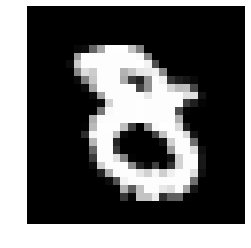

In [6]:
idx = torch.randint(0, len(train_data), (1, )).item()
random_image = train_data[idx][0].squeeze().numpy()
target_num = train_data[idx][1]
print("Target: {}".format(target_num))
print("Size of Image: {}".format(random_image.shape))
plt.imshow(random_image, cmap = "gray")
plt.axis("off")
plt.show()

Setting device on GPU if available, else CPU

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## 2. Define your own Neural Network

<img src = "./Images/MNIST_Network.png" align = "left">

It is time to build a neural network that classifies this dataset with PyTorch. Its input should be 784 (= 28 * 28) and output of 10. We can add more layers or deep learning techniques to increase the accuracy. 
<br> `nn.Sequential` is a 'sequential' container that modules such as Linear, Conv2D, and ReLU, are contained. It processes in the order the user put methods on it. </br>
<br> `forward` function actually processes the `self.main`. Reading the below code will help understanding.
<br>Image source: http://neuralnetworksanddeeplearning.com/chap1.html </br>

In [8]:
# define hyper-parameters

input_size = 28 * 28 # (= 784)
hidden_size = [512, 256, 64] # multi-layer perceptron
num_classes = 10
learning_rate = 0.001

In [9]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Model, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]),
            nn.ReLU(),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.ReLU(),
            nn.Linear(hidden_size[2], num_classes)
        )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [10]:
model = Model(input_size, hidden_size, num_classes)

In [11]:
print(model.to(device))

Model(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


Before the training process, cost function and optimizer should be declared for forward and backward pass. The reason for using CrossEntropyLoss instead of Softmax is that the former contains the latter. Adam optimizer is the best operating optimization so far. The learning rate is typically set to 0.01 or 0.001.

In [12]:
# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

## 3. Train the Model

To perform AI-like tasks, in this case classification, the neural network must be trained using a large dataset - MNIST. All data of MNIST iterate per one epoch. First, declare `model.train()` to put the model in the training process. As PyTorch sets the gradients by default, declaring `optimizer.zero_grad()` is essential. Then it will loop through the mini batches of MNIST dataset and data will pass through the network and calculate the losses, gradients and run the optimizer.

In [13]:
def train(model, num_epochs):
    model.train()
    
    for epoch in range(num_epochs):
        total_batch = len(train_data) // batch_size
    
        for i, (batch_images, batch_labels) in enumerate(train_loader):
        
            X = batch_images.view(-1, 28 * 28)
            Y = batch_labels
        
            ### The below five lines should be memorized for further use.
            # forward pass
            pred = model(X)
            # calculation of loss value
            cost = criterion(pred, Y)
            # Adding cost value to the cost_losses class for graph plot later.
            # train_cost.append(cost.item())
            
            ## backward pass and optimization
            # gradient initialization
            optimizer.zero_grad()
            # backward pass
            cost.backward()
            # parameter update
            optimizer.step()
        
            # print statistics of training process
            if (i+1) % 300 == 0:
                print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                     %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
            #train_count.append((i * 64) + ((epoch - 1) * len(train_loader.dataset)))
    
    print("Learning Finished!")

In [14]:
train(model = model, num_epochs = 7)

Epoch [1/7], lter [300/937], Loss: 0.2844
Epoch [1/7], lter [600/937], Loss: 0.1562
Epoch [1/7], lter [900/937], Loss: 0.3172
Epoch [2/7], lter [300/937], Loss: 0.1292
Epoch [2/7], lter [600/937], Loss: 0.2046
Epoch [2/7], lter [900/937], Loss: 0.0919
Epoch [3/7], lter [300/937], Loss: 0.0655
Epoch [3/7], lter [600/937], Loss: 0.0367
Epoch [3/7], lter [900/937], Loss: 0.0228
Epoch [4/7], lter [300/937], Loss: 0.0302
Epoch [4/7], lter [600/937], Loss: 0.1029
Epoch [4/7], lter [900/937], Loss: 0.0693
Epoch [5/7], lter [300/937], Loss: 0.1166
Epoch [5/7], lter [600/937], Loss: 0.0452
Epoch [5/7], lter [900/937], Loss: 0.0972
Epoch [6/7], lter [300/937], Loss: 0.0440
Epoch [6/7], lter [600/937], Loss: 0.0823
Epoch [6/7], lter [900/937], Loss: 0.0426
Epoch [7/7], lter [300/937], Loss: 0.0069
Epoch [7/7], lter [600/937], Loss: 0.3234
Epoch [7/7], lter [900/937], Loss: 0.0096
Learning Finished!


## 4. Test the Model

After training the model, it is vital to evaluate the model with other sets of data, which are never used for  First, run `model.eval()` to set the model to evaluation mode. It turns off any drop-out or batch normalization layers in the model that should not be used during the test. `torch.no_grad()` disables autograd function. 

In [15]:
def test(model):
    
    # declare that the model is about to evaluate
    model.eval()

    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_data:
            images = images.view(-1, 28 * 28).to(device)
            
            # forward pass
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += 1
            correct += (predicted == labels).sum().item()

    print("Accuracy of Test Images: %f %%" % (100 * float(correct) / total))

In [16]:
test(model = model)

Accuracy of Test Images: 97.070000 %


## 5. Demonstrate the Model
It imports an image from test dataset and see if the learning is conducted properly or not.

In [17]:
r = random.randint(0, len(test_data)-1)
X_single_data = Variable(test_data.test_data[r:r + 1].view(-1,28*28).float())
Y_single_data = Variable(test_data.test_labels[r:r + 1])

Label:  [6]
Prediction:  [6]


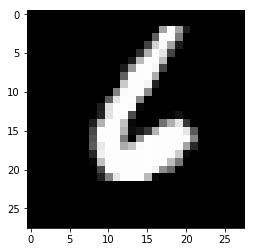

In [18]:
single_prediction = model(X_single_data)
plt.imshow(X_single_data.data.view(28, 28).numpy(), cmap='gray')

print('Label: ', Y_single_data.data.view(1).numpy())
print('Prediction: ', torch.max(single_prediction.data, 1)[1].numpy())

## 6. Save the Model

Saving the checkpoint of the model is always important as we might load it for later usage.

In [19]:
# Save the model checkpoint
save_path = './model/'

if not os.path.exists(save_path):
    os.makedirs(save_path)

torch.save(model.state_dict(), 'basic_nn.ckpt')